# TargetFeed A/B
**Дизайн и подведение итогов A/B  эксперимента**

Дата: 05.06.2025

**Описание задания:**
Компания разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Необходимо рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. 

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. 

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02.  

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Задача: 
Рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

## Работа с историческими данными (EDA)

#### Загрузка исторических данных

In [1]:
#загружаем нужные для работы библиотеки и функции
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower

In [3]:
# Уменьшение разрешения DPI для графиков 
plt.rcParams['figure.dpi'] = 72

In [4]:
from math import ceil

In [5]:
# Загружаем библиотеку для диаграмм Венна
#!pip install matplotlib-venn -q
from matplotlib_venn import venn2

In [6]:
#загружаем исторические данные
try:
    sessions_history = pd.read_csv('datasets/sessions_project_history.csv')
    display('Файл sessions_project_history.csv загружен в датасет sessions_history')
except:
    display('Ошибка загрузки файла sessions_project_history.csv')

'Файл sessions_project_history.csv загружен в датасет sessions_history'

In [7]:
#смотрим на данные
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [8]:
# анализируем структуру датафрейма
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


Датафрейм с историческими данными **sessions_history** содержит 10 столбцов и 435924 строки. Данные соответствуют заявленным и содержат информацию о взаимодействии пользователей с развлекательным приложением. Пропуски в данных - отсутствуют. 

In [9]:
#анализируем числовые данные датафрейма
sessions_history.describe()

,session_number,registration_flag,page_counter
count,435924.000000,435924.000000,435924.000000
mean,2.382908,0.077325,3.005561
std,1.288487,0.267107,1.024625
min,1.000000,0.000000,1.000000
25%,1.000000,0.000000,2.000000
50%,2.000000,0.000000,3.000000
75%,3.000000,0.000000,4.000000
max,10.000000,1.000000,7.000000


Числовые данные следующие:
* Номер сессии - от 1 до 10, 
* Флаг регистрации - 0 и 1, 
* Количество просмотренных страниц - от 1 до 7, в среднем - 3 страницы за сессию.

Среднее и медиана в столбцах session_number	и page_counter практически совпадают, что говорит об отсутствии выбросов.

#### Знакомство с данными

Проверим исторические данные на дубликаты.

In [10]:
display(f'Полных дубликатов {sessions_history.duplicated().sum()} строк')

'Полных дубликатов 0 строк'

In [11]:
display(f'Дубликатов по ID сессии {sessions_history.duplicated(subset = ["session_id"]).sum()} строк')

'Дубликатов по ID сессии 0 строк'

Дубликатов не обнаружено. Одна строка - одна сессия.

In [12]:
#по историческим данным рассчитываем количество сессий для каждого пользователя
user_sessions = sessions_history.groupby('user_id').agg({'session_number' : 'nunique'}).reset_index()

In [13]:
#выбираем пользователя с max количеством сессий
user_max_sessions = user_sessions.sort_values(by='session_number', ascending=False)['user_id'].iloc[0]
display(f'ID пользователя с MAX количеством сессий: {user_max_sessions}')

'ID пользователя с MAX количеством сессий: 10E0DEFC1ABDBBE0'

In [14]:
# выводим данные для пользователя с max количеством сессий
sessions_history.loc[sessions_history['user_id'] == user_max_sessions]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### Анализ числа регистраций

Одна из важнейших метрик продукта — число зарегистрированных пользователей (у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться). Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

In [15]:
#число уникальных пользователей по дням
df_user_date = sessions_history.groupby('session_date').agg({'user_id' : 'nunique'}).reset_index()

In [16]:
#число зарегистрированных пользователей по дням
df_reg_user_date = sessions_history.loc[sessions_history['registration_flag'] == 1].groupby('session_date').agg({'user_id' : 'nunique'}).reset_index()

In [17]:
#объединяем данные в одну таблицу и добавляем столбец для расчета доли
df_days = df_user_date.merge(df_reg_user_date, on='session_date', how='left')
df_days.insert(3, 'part', 0)

In [18]:
# рассчитываем долю зарегистрированных пользователей
df_days['part'] = df_days['user_id_y']/df_days['user_id_x']
df_days.head()

,session_date,user_id_x,user_id_y,part
0,2025-08-11,3919,169,0.043123
1,2025-08-12,6056,336,0.055482
2,2025-08-13,8489,464,0.054659
3,2025-08-14,10321,625,0.060556
4,2025-08-15,14065,840,0.059723


In [19]:
#считаем среднее количество пользователей в день
avg_daily_users = int(df_days['user_id_x'].mean())

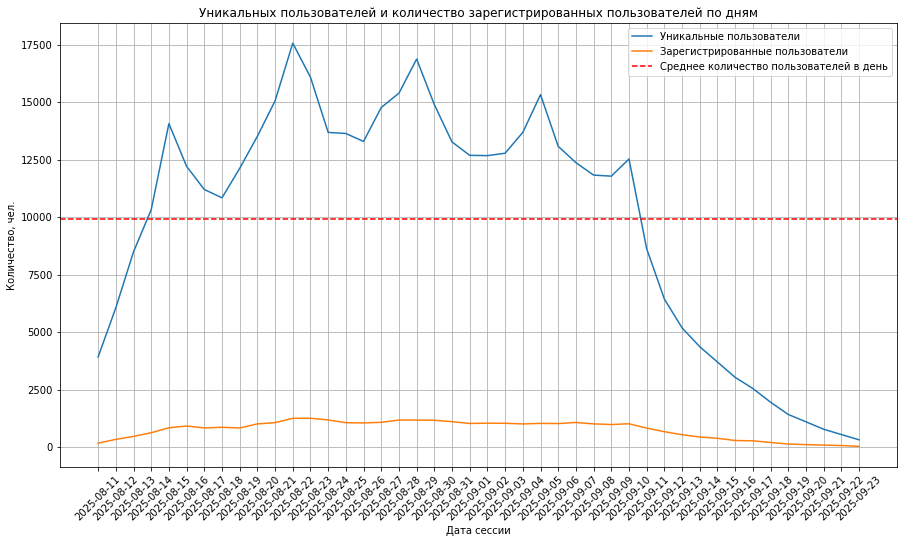

In [20]:
#Строим первый график
x = df_days['session_date'].unique()
y_1 = df_days['user_id_x']
y_2 = df_days['user_id_y']
plt.figure(figsize = (15,8))

plt.plot(x, y_1, label = 'Уникальные пользователи' )           
plt.plot(x, y_2, label = 'Зарегистрированные пользователи' )
plt.title('Уникальных пользователей и количество зарегистрированных пользователей по дням')
plt.xlabel('Дата сессии')
plt.xticks(rotation=45)
plt.ylabel('Количество, чел.')
plt.grid()
plt.axhline(avg_daily_users, color='red', linestyle='--', label="Среднее количество пользователей в день")
plt.legend()
plt.show()

In [21]:
# среднее значение доли зарегистрированных за весь период
avg_part_daily_users = df_days['part'].mean()

In [22]:
# вычисляем день с MAX значением доли
max_part_day = df_days.loc[df_days['part'] == df_days['part'].max(), 'session_date']
max_part_day = max_part_day.to_string(index=False)

In [23]:
# вычисляем день с MIN значением доли
min_part_day = df_days.loc[df_days['part'] == df_days['part'].min(), 'session_date']
min_part_day = min_part_day.to_string(index=False)

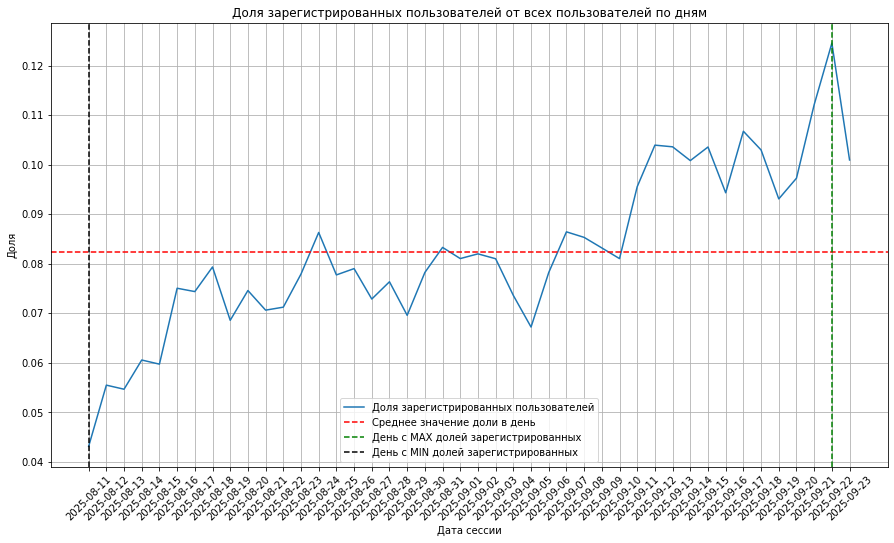

In [24]:
#Строим второй грфик - доля зарегистрированных от общего количества пользователей
x = df_days['session_date']
y = df_days['part']
plt.figure(figsize = (15,8))
plt.plot(x, y, label = 'Доля зарегистрированных пользователей' )  
plt.title('Доля зарегистрированных пользователей от всех пользователей по дням')
plt.xlabel('Дата сессии')
plt.xticks(rotation=45)
plt.ylabel('Доля')
plt.axhline(avg_part_daily_users, color='red', linestyle='--', label="Среднее значение доли в день")
plt.axvline(max_part_day, color='green', linestyle='--', label="День с MAX долей зарегистрированных")
plt.axvline(min_part_day, color='black', linestyle='--', label="День с MIN долей зарегистрированных")
plt.legend()
plt.grid()
plt.show()

#### Анализ числа просмотренных страниц

Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.
Найдем количество сессий для каждого значения количества просмотренных страниц. (Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.)
Построим столбчатую диаграмму, по оси X - число просмотренных страниц, по оси Y — количество сессий.

In [25]:
count_sessions_for_page = sessions_history.groupby('page_counter').agg({'session_id' : 'nunique'}).reset_index()

In [26]:
count_sessions_for_page.head(10)

,page_counter,session_id
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


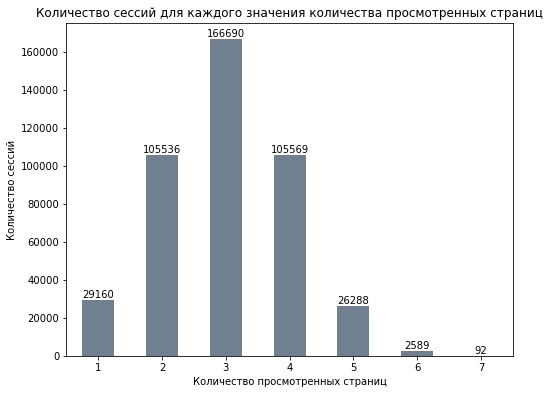

In [27]:
# Строим столбчатую диаграмму
count_sessions_for_page.plot(kind='bar',
                             x = 'page_counter',
                             y = 'session_id',
                             title='Количество сессий для каждого значения количества просмотренных страниц',
                             legend=False,
                             ylabel='Количество сессий',
                             xlabel='Количество просмотренных страниц',
                             rot=0,
                             color='slategray',
                             figsize=(8, 6)) 

#подписи значений над столбцами:
for i, v in enumerate(count_sessions_for_page['session_id'].values):
    plt.text(count_sessions_for_page.index[i], v, str(v), ha='center', va='bottom')

plt.show()

#### Доля пользователей, просмотревших более четырёх страниц

Продуктовая команда считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

Создадим дополнительный столбец `good_session` в датафрейме `sessions_history`. Значение =`1`, если за одну сессию было просмотрено 4 и более страниц, и =`0`, если было просмотрено меньше.

Построим график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [28]:
#проверим датафрейм на дубликаты по полю "Идентификатор сесии" 
count_dub = sessions_history.duplicated('session_id').sum()
display(count_dub)

np.int64(0)

Дубликатов по ID сессии нет, значит - одна строка - одна сессия.

In [29]:
#считтаем сколько всего сессий
all_sessions = sessions_history.shape[0]

In [30]:
# добавим столбец на 9 позицию рядом с количеством страниц для удобства и заполним нулями
sessions_history.insert(8, 'good_session', 0)

In [31]:
#проставляем признак успешности сессии
sessions_history.loc[sessions_history['page_counter'] >= 4, 'good_session'] = 1
#проверяем
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,good_session,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,0,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,1,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,1,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,1,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,0,CIS,Android


In [32]:
#считаем сумму успешных сессий за по дням
df_good_sessions = sessions_history.groupby('session_date').agg({'good_session' : 'sum'}).reset_index()

In [33]:
df_good_sessions['good_session'] = round(df_good_sessions['good_session']/all_sessions,6)
df_good_sessions.head()

,session_date,good_session
0,2025-08-11,0.002812
1,2025-08-12,0.004196
2,2025-08-13,0.005974
3,2025-08-14,0.007483
4,2025-08-15,0.009839


In [34]:
# Среднее значение за весь период
mean_all = df_good_sessions["good_session"].mean()

# Среднее значение за последний период (например, последние 7 дней)
mean_last_period = df_good_sessions.tail(7)["good_session"].mean()

print(f"Среднее за весь период: {mean_all}")
print(f"Среднее за последний период: {mean_last_period}")

Среднее за весь период: 0.007014318181818182
Среднее за последний период: 0.0008702857142857143


In [35]:
# Расчет стандартного отклонения 
std_dev = df_good_sessions["good_session"].std()
print(f"Стандартное отклонение за весь период: {std_dev}")    

Стандартное отклонение за весь период: 0.003716831106978264


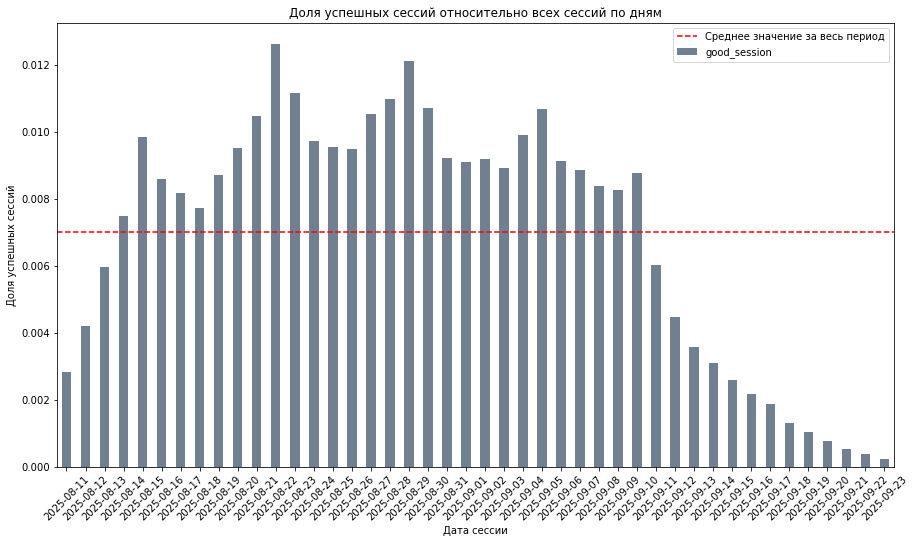

In [36]:
# Строим столбчатую диаграмму
df_good_sessions.plot(kind='bar',
                      x = 'session_date',
                      y = 'good_session',
                      title='Доля успешных сессий относительно всех сессий по дням',
                      ylabel='Доля успешных сессий',
                      xlabel='Дата сессии',
                      rot=45,
                      color='slategray',
                      figsize=(15, 8)) 
# Линия среднего значения
plt.axhline(mean_all, color='red', linestyle='--', label="Среднее значение за весь период")
plt.legend()
plt.show()

## Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.
- Рассчитать необходимый размер выборки.
- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

### Выбор целевой метрики.

Выбираем целевую метрику. В нашем случае - это увеличение доли сессий с четырьмя и более просмотренными страницами.
Другие метрики, которые необходимо отслеживать - отсутствие изменения числа сессий в день.
Особенности проведения теста - вовлекается все аудитория приложения.

### Расчёт размера выборки

Установим следующие параметры:

- Уровень значимости — 0.05.
- Вероятность ошибки второго рода — 0.2.
- Мощность теста = 0,8
- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

In [37]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект (указывается дробь, а не процент)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


### Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитаем длительность теста, разделив одно на другое.
- Рассчитаем среднее количество уникальных пользователей приложения в день.
- Определием длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. 

In [38]:
# Считаем среднее количество пользователей приложения в день по историческим данным
avg_daily_users = int(sessions_history.groupby('session_date')['user_id'].nunique().mean())
display(f'Cреднее количество уникальных пользователей приложения в день: {avg_daily_users}')

'Cреднее количество уникальных пользователей приложения в день: 9907'

In [39]:
# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(int(sample_size)*2/avg_daily_users)

display(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

'Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 4 дней'

## Мониторинг А/В-теста

### Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Используем CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.
- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.
- Рассчитаем и визуализируем процентную разницу в количестве пользователей в группах A и B. 

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [40]:
#выгружаем данные за 1 день теста
try:
    sessions_test_part = pd.read_csv('datasets/sessions_project_test_part.csv')
    display('Файл sessions_project_test_part.csv загружен в датасет sessions_test_part')
except:
    display('Ошибка загрузки файла sessions_project_test_part.csv')

'Файл sessions_project_test_part.csv загружен в датасет sessions_test_part'

In [41]:
#смотрим данные
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [42]:
#проверяем - действительно ли у нас данные за один день или несколько
sessions_test_part['session_date'].unique()

array(['2025-10-14'], dtype=object)

In [43]:
#считаем количество пользователей в группе А
count_users_A = sessions_test_part['user_id'].loc[sessions_test_part['test_group'] == 'A'].nunique()
display(f'Первый день эксперимента. Количество пользователей в группе А: {count_users_A}')

'Первый день эксперимента. Количество пользователей в группе А: 1477'

In [44]:
#считаем количество пользователей в группе B
count_users_B = sessions_test_part['user_id'].loc[sessions_test_part['test_group'] == 'B'].nunique()
display(f'Первый день эксперимента. Количество пользователей в группе B: {count_users_B}')

'Первый день эксперимента. Количество пользователей в группе B: 1466'

In [45]:
#Считаем процентную разницу
P = 100*abs((count_users_A - count_users_B)/count_users_A)
display(f'Процентная разница в количестве пользователей в группах A и B: {P}')

'Процентная разница в количестве пользователей в группах A и B: 0.7447528774542992'

Визуализируем на круговой диаграмме

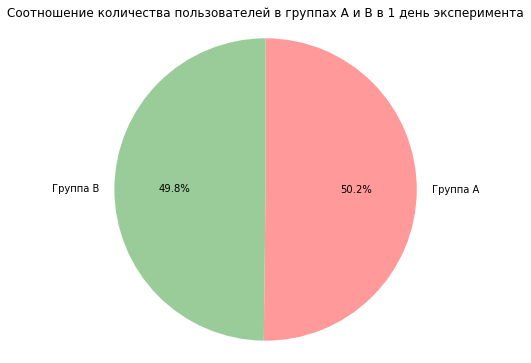

In [46]:
#строим круговую диаграмму
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie([count_users_A,count_users_B], labels=['Группа А','Группа В'], autopct='%1.1f%%', startangle=90,\
        colors=['#ff999a','#9acc99'], counterclock=False)
plt.axis('equal')
ax.set_title('Соотношение количества пользователей в группах А и В в 1 день эксперимента')
plt.show()

**Вывод:** наглядно видно, что количество пользователей в группах А и В практически одинаковое.

### Проверка пересечений пользователей

Помимо проверки равенства количества пользователей в группах убедимся в том, что группы независимы и никто из пользователей случайно не попал в обе группы одновременно.
- Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B.

In [47]:
#создаем мнгожество уникальных ID пользователей в группе А
set_users_A = set(sessions_test_part['user_id'].loc[sessions_test_part['test_group'] == 'A'])
display(f'Количество уникальных пользователей в группе А: {len(set_users_A)}')

'Количество уникальных пользователей в группе А: 1477'

In [48]:
#создаем мнгожество уникальных ID пользователей в группе B
set_users_B = set(sessions_test_part['user_id'].loc[sessions_test_part['test_group'] == 'B'])
display(f'Количество уникальных пользователей в группе B: {len(set_users_B)}')

'Количество уникальных пользователей в группе B: 1466'

In [49]:
#считаем пересечения в множествах
set_A_B = len(set_users_A.intersection(set_users_B))
display(f'Количество пересечений пользователей в грппах А и В: {set_A_B}') 

'Количество пересечений пользователей в грппах А и В: 0'

Визуализируем пересечения множеств никнеймов на диграмме Венна

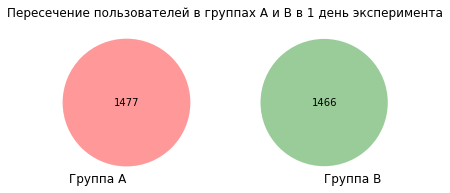

In [50]:
# Строим диаграмму Венна
v = venn2(subsets=[set_users_A, set_users_B], \
          set_labels=('Группа А', 'Группа B'))
plt.title("Пересечение пользователей в группах А и В в 1 день эксперимента")
plt.show()   

**Вывод:** Наглядно видно, что в группах А и В нет пересечений пользователей.

### Равномерность разделения пользователей по устройствам

Убедимся также, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Нужно провести анализ по уникальным пользователям. Проверим дублирование "пользователь-устройство".

In [51]:
display(f'В данных {sessions_test_part.duplicated(["user_id","device"]).sum()} строк дублирования по user_id и устройству')

'В данных 187 строк дублирования по user_id и устройству'

Для простоты можно удалить дубли, оставив одну строчку по пользователю и скопировав данные в другой датафрейм, но можно применить и группировку.

In [52]:
# выбираем устройства по уникальным пользователей
device_table = sessions_test_part.groupby(['test_group','device'])['user_id'].nunique().reset_index()
display(device_table)

,test_group,device,user_id
0,A,Android,656
1,A,Mac,156
2,A,PC,369
3,A,iPhone,296
4,B,Android,668
5,B,Mac,148
6,B,PC,381
7,B,iPhone,269


In [53]:
#считаем общее количество устройств в группе A
count_device_A = device_table.loc[device_table['test_group'] == 'A']['user_id'].sum()
display(f'В группе А всего {count_device_A} устройств')

'В группе А всего 1477 устройств'

In [54]:
#считаем общее количество устройств в группе B
count_device_B = device_table.loc[device_table['test_group'] == 'B']['user_id'].sum()
display(f'В группе B всего {count_device_B} устройств')

'В группе B всего 1466 устройств'

In [55]:
# группируем в сводную таблицу для графика
device_table = pd.pivot_table(device_table, index='test_group', columns='device', values='user_id',  aggfunc='sum')
display(device_table)

device,Android,Mac,PC,iPhone
test_group,,,,
A,656,156,369,296
B,668,148,381,269


In [56]:
#Вычисляем долю устройств в каждой группе

#Преобразуем нужные столбцы во float, чтобы избежать предупреждения
cols_to_fix = ['Android', 'Mac', 'PC', 'iPhone']
device_table[cols_to_fix] = device_table[cols_to_fix].astype(float)

if count_device_A > 0:
    device_table.loc['A'] = (device_table.loc['A'] / count_device_A).round(3)
if count_device_B > 0:
    device_table.loc['B'] = (device_table.loc['B'] / count_device_B).round(3)

display(device_table)    

device,Android,Mac,PC,iPhone
test_group,,,,
A,0.444,0.106,0.25,0.200
B,0.456,0.101,0.26,0.183


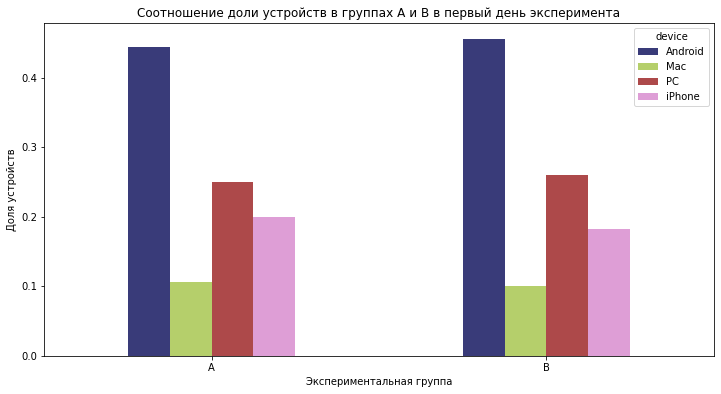

In [57]:
#Строим график 
device_table.plot(kind='bar',
                  figsize=(12,6),
                  title='Соотношение доли устройств в группах А и В в первый день эксперимента',
                  ylabel='Доля устройств',
                  xlabel='Экспериментальная группа',
                  rot=0,
                  legend=True,
                  colormap='tab20b')         
plt.show()

**Вывод:** наглядно видно, что распределение устройств уникальных пользователей в группах А и В равномерно.

### Равномерность распределения пользователей по регионам

Теперь убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:
- доля каждого региона для пользователей из группы A,
- доля каждого региона для пользователей из группы B.

Ранее выяснили, что в данных 187 дублированных строк по id пользователя. 

In [58]:
# выбираем устройства по уникальным пользователей
df_region = sessions_test_part.groupby(['test_group','region'])['user_id'].nunique().reset_index()
display(df_region)

,test_group,region,user_id
0,A,CIS,644
1,A,EU,224
2,A,MENA,609
3,B,CIS,645
4,B,EU,217
5,B,MENA,604


In [59]:
# группируем в сводную таблицу для графика
df_region = pd.pivot_table(df_region, index='test_group', columns='region', values='user_id',  aggfunc='sum')
display(df_region)

region,CIS,EU,MENA
test_group,,,
A,644,224,609
B,645,217,604


In [60]:
#Считаем долю регионов, используя уже посчитанное общее количество пользователей в группах (в пункте 2.3.2)

#Преобразуем нужные столбцы во float, чтобы избежать предупреждения
cols_to_fix = ['CIS', 'EU', 'MENA']
df_region[cols_to_fix] = df_region[cols_to_fix].astype(float)

if len(set_users_A)>0:
    df_region.loc['A'] = round(df_region.loc['A']/len(set_users_A),3)
if len(set_users_B)>0:    
    df_region.loc['B'] = round(df_region.loc['B']/len(set_users_B),3)
    
display(df_region)

region,CIS,EU,MENA
test_group,,,
A,0.436,0.152,0.412
B,0.440,0.148,0.412


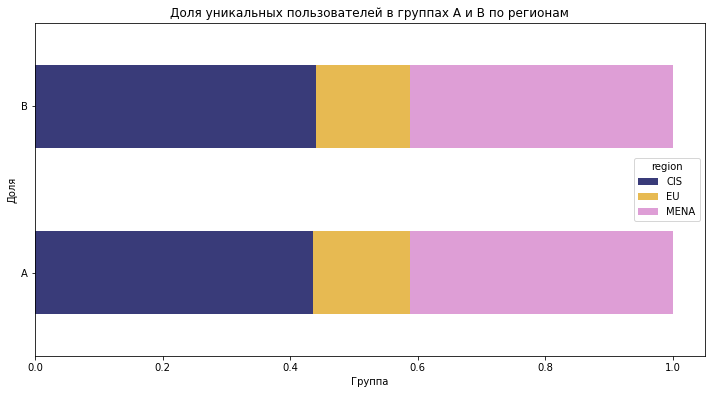

In [61]:
#Строим график 
df_region.plot(kind='barh',
               stacked=True,
               figsize=(12,6),
               title='Доля уникальных пользователей в группах А и В по регионам',
               ylabel='Доля',
               xlabel='Группа',
               rot=0,
               legend=True,
               colormap='tab20b')         
plt.show()

**Вывод:** наглядно видно, что распределение пользователей по регионам в группах А и В  - равномерно.

### Вывод на этапе мониторинга A/B-теста

Анализ данных по одному дню эксперимента показал:
1. Пользователи в группах А и В в выборке данных распределены практически равномерно. В группе А - 50,2% пользователей (1477 человек), в группе В - 49,8% пользователей (1466 человек).
2. Выборки являются независимыми. Пересечений пользователей из контрольной (А) и тестовой групп (В) - не выявлено.
3. Количество устройств в группе А больше, чем в группе В: 1628 и 1502 соответственно. Но распределение пользователей по доли  устройства от общего количества устройств в группах А и В - равномерное.
4. Распределение доли пользователей по категории "регион"  в обеих группах - равномерное.

## Проверка результатов A/B-теста

A/B-тест завершён, и есть результаты за все дни проведения эксперимента. Убедимся в корректности теста и интерпретируем результаты.

### Получение результатов теста и подсчёт основной метрики

Используем CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [62]:
#выгружаем данные теста
try:
    sessions_test = pd.read_csv('datasets/sessions_project_test.csv')
    display('Файл sessions_project_test.csv загружен в датасет sessions_test')
except:
    display('Ошибка загрузки файла sessions_project_test.csv')

'Файл sessions_project_test.csv загружен в датасет sessions_test'

In [63]:
# добавим столбец на 9 позицию рядом с количеством страниц для удобства и заполним нулями
sessions_test.insert(8, 'good_session', 0)

In [64]:
#проставляем признак успешности сессии
sessions_test.loc[sessions_test['page_counter'] >= 4, 'good_session'] = 1

### Проверка корректности результатов теста

Сначала убедимся, что тест проведён корректно и две тестовые группы сопоставимы.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.
- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. 
Используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

In [65]:
# Считатем количество уникальных сессий для каждого дня обеих тестовых групп
sessions_test_days = sessions_test.groupby(['test_group','session_date']).agg({'session_id' : 'nunique'}).reset_index()
display(sessions_test_days)

,test_group,session_date,session_id
0,A,2025-10-14,1502
1,A,2025-10-15,2235
2,A,2025-10-16,3280
3,A,2025-10-17,4089
4,A,2025-10-18,5013
5,A,2025-10-19,6535
6,A,2025-10-20,5837
7,A,2025-10-21,3927
8,A,2025-10-22,3083
9,A,2025-10-23,2470


In [66]:
# Проверяем, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы.
# Используем двухвыборочный статистический t-тест Стъюдента
# Гипотеза H0 - различий между средними двух выборок НЕТ
# Гипотеза H1 - различия между средними двух выборок ЕСТЬ

alpha = 0.05 # Уровень значимости

group_A = sessions_test_days.loc[sessions_test_days['test_group'] == 'A', 'session_id']
group_B = sessions_test_days.loc[sessions_test_days['test_group'] == 'B', 'session_id']

results = st.ttest_ind(group_A, group_B, alternative = 'two-sided') # тест

if results.pvalue >= alpha:
   display(f'Значение p-value {results.pvalue} >= {alpha}. Количество уникальных дневных сессий в двух выборках - равнозначно.')
else:
    display(f'Значение p-value {results.pvalue} < {alpha}. Количество уникальных дневных сессий в двух выборках - НЕ равнозначно.')

'Значение p-value 0.938219304859116 >= 0.05. Количество уникальных дневных сессий в двух выборках - равнозначно.'

In [67]:
#Проверим то же самое тестом Манна — Уитни

results = st.mannwhitneyu(group_A, group_B, alternative = 'two-sided')

if results.pvalue >= alpha:
   display(f'Значение p-value {results.pvalue} >= {alpha}. Количество уникальных дневных сессий в двух выборках - равнозначно.')
else:
    display(f'Значение p-value {results.pvalue} < {alpha}. Количество уникальных дневных сессий в двух выборках - НЕ равнозначно.')

'Значение p-value 0.8817307917391243 >= 0.05. Количество уникальных дневных сессий в двух выборках - равнозначно.'

### Сравнение доли успешных сессий

Количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используя столбец `good_session`, рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе. 

In [68]:
# Cчитаем размер группы A
n_A = sessions_test[ sessions_test.test_group=='A'].shape[0] 

# Cчитаем размер группы B
n_B = sessions_test[ sessions_test.test_group=='B'].shape[0] 

display(f'Размеры групп: A:{n_A}, B:{n_B}')

'Размеры групп: A:49551, B:50454'

In [69]:
#Считаем количество успешных сессий в группе A
m_A = sessions_test[(sessions_test.test_group == 'A') & (sessions_test.good_session == 1)].shape[0] 

#Считаем количество успешных сессий в группе B
m_B = sessions_test[(sessions_test.test_group == 'B') & (sessions_test.good_session == 1)].shape[0] 

display(f'Количество успешных сессий в группах: A:{m_A}, B:{m_B}')

'Количество успешных сессий в группах: A:15248, B:16059'

In [70]:
#Считаем доли успешных сессий для каждой группы: A и B
p_A = m_A/n_A
p_B = m_B/n_B 
display(f'Доли успешных сессий в группах: A:{p_A}, B:{p_B}')

'Доли успешных сессий в группах: A:0.3077233557344958, B:0.31828992745867524'

In [71]:
if p_A >= p_B:
    display(f'Доля успешных сессий в контрольной группе A выше, чем в тестовой B на {round((p_A/p_B)*100 - 100,2)}%')
else: 
    display(f'Доля успешных сессий в тестовой группе B выше, чем в контрольной A на {round((p_B/p_A)*100 - 100,2)}%')  

'Доля успешных сессий в тестовой группе B выше, чем в контрольной A на 3.43%'

### Насколько статистически значимо изменение ключевой метрики

Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.
- Выведите полученное значение p-value и свои выводы о статистической значимости. 

Для анализа долеи успешных сессий в выборках используем Z-тест пропорций.

In [72]:
# Сначала проверим предпосылку о достаточном количестве данных в выборках А и В
if (p_A*n_A > 10) and ((1-p_A)*n_A > 10) and (p_B*n_B > 10) and ((1-p_B)*n_B > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

Предпосылка о достаточном количестве данных выполняется!


In [73]:
alpha = 0.05 ## уровень значимости

# [m_A, m_B] - массивы из количества успехов
# [n_A, n_B] - массивы размеров выборок
# H0 - доля успешных сессий в контрольной выборке вольше, чем в тестовой pA > PB
# H1 - доля успешных сессий в контрольной выборке меньше, чем в тестовой pA < PB

stat_ztest, p_value_ztest = proportions_ztest([m_A, m_B],[n_A, n_B], alternative='smaller')

print(f'pvalue={p_value_ztest}') # выведите полученное p-value 

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение! Доля успешных сессий в контрольной выборке А больше, чем в тестовой В')
else:
    print('Нулевая гипотеза не находит подтверждения! Принимаем альтернативную гипотезу: доля успешных сессий в контрольной выборке A меньше, чем в тестовой B.')


pvalue=0.0001574739988036123
Нулевая гипотеза не находит подтверждения! Принимаем альтернативную гипотезу: доля успешных сессий в контрольной выборке A меньше, чем в тестовой B.


### Вывод по результатам A/B-эксперимента

1.Суть проводимого эксперимента: новый алгоритм рекомендаций, который показывает более интересный контент для каждого пользователя, принесет увеличение доли успешных сессий на 3%. Ключевая метрика - доля успешных сессий (сессия, в которой количество просмотренных страниц >=4). Длительность эксперимента: 4 дня, количество пользователей в каждой группе -  17441 человек.

2.По результатам эксперимента выявлено, что внедрение нового алгоритма рекомендаций увеличило ключевую метрику (долю успешных сессий относительно всех сессий) в тестовой группе на 0,01056657172418 пункта, что составляет 3,43%.

3.Значение p-value для оценки статистической значимости выявленного эффекта составляет 0.0001574739988036123, что значительно меньше уровня значимости = 0.05. 

4.Предполагаемый минимальный детектируемый эффект (MDE) = 3%, a реальный MDE в результате эксперимента составил 3,43%.  Изменение в тестовой группе является статистически значимым. Нововведение стоит внедрить.

# Итоговый вывод по проекту

В проекте TargetFeed A/B проделана следующая работа:

1. Данные выгружены из файлов *.csv и загружены в датафреймы:
 - `sessions_history` — исторические данные по сессиям пользователей;
 - `sessions_test_part` — данные за первый день проведения A/B-теста;
 - `sessions_test` —  данные за весь период проведения A/B-теста.
2. Данные проанализированны на корректность, полноту, дубликаты, рассчитаны основные метрики продукта:
- число зарегистрированных пользователей;
- число просмотренных страниц в приложении;
- доля пользователей, просмотревших более четырёх страниц.
3. На этапе подготовки к тесту:
- выбрана целевая метрика (увеличение доли сессий с четырьмя и более просмотренными страницами),
- выбрана вспомогательная метрика (отсутствие изменения числа сессий в день).

Установлены параметры теста:
- Уровень значимости — 0.05.
- Вероятность ошибки второго рода — 0.2.
- Минимальный детектируемый эффект (MDE) — 3%.

Рассчитаны: 
- размер выборки:  для каждой группы: 17441;
- длительность теста: при текущем уровене трафика в 9907 пользователей в день составит 4 дней.
  
4. Проведен мониторинг теста по данным за первый день. Проверено, что  
- пользователи разделены правильным образом - равномерно и без пересечений. В группе А - 50,2% пользователей (1477 человек), в группе В - 49,8% пользователей (1466 человек). Группы независимы. Распределение в группах по устройствам и регионам - равномерное.
- метрики считаются корректно.
5. На этапе анализа результатов эксперимента оценена корректность его проведения и проанализированы его результаты:
- вспомогательная метрика - количество уникальных дневных сессий в двух выборках - равнозначное,
- ключевая метрика (доля успешных сессий относительно всех сессий) в тестовой группе выше, чем в контрольной на 3.43%'
- изменение в тестовой группе является статистически значимым, pvalue=0.0001574739988036123, что значительно меньше уровня значимости(0.05).  
- реальный минимальный детектируемый эффект (MDE) = 3,43%, что выше предполагаемого MDE)= 3%.  

Вывод - нововведение следует внедрить.